## MLP ( Multi-layer Perceptron )

In [1881]:
# Importando as libs que serão usadas
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [1882]:
# Importando as funções que serão usadas no código

from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from yellowbrick.classifier import ConfusionMatrix
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from scipy.stats import uniform

In [1883]:
# Importando a base de dados

df = pd.read_csv('breast-cancer.csv', sep=',')
df.head(5)

,age,menopause,tumor-size,inv-nodes,node-caps,deg-malig,breast,breast-quad,irradiat,Class
0,40-49,premeno,15-19,0-2,yes,3,right,left_up,no,recurrence-events
1,50-59,ge40,15-19,0-2,no,1,right,central,no,no-recurrence-events
2,50-59,ge40,35-39,0-2,no,2,left,left_low,no,recurrence-events
3,40-49,premeno,35-39,0-2,yes,3,right,left_low,yes,no-recurrence-events
4,40-49,premeno,30-34,3-5,yes,2,left,right_up,no,recurrence-events


In [1884]:
# Verificando se possui valores nulos

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 286 entries, 0 to 285
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   age          286 non-null    object
 1   menopause    286 non-null    object
 2   tumor-size   286 non-null    object
 3   inv-nodes    286 non-null    object
 4   node-caps    286 non-null    object
 5   deg-malig    286 non-null    int64 
 6   breast       286 non-null    object
 7   breast-quad  286 non-null    object
 8   irradiat     286 non-null    object
 9   Class        286 non-null    object
dtypes: int64(1), object(9)
memory usage: 22.5+ KB


In [1885]:
# Verificando a distribuicao dos dados

df.describe()

,deg-malig
count,286.000000
mean,2.048951
std,0.738217
min,1.000000
25%,2.000000
50%,2.000000
75%,3.000000
max,3.000000


In [1886]:
# Verificando os dados unicos das colunas

def unique_values(df):
    for column in df.columns:
        unique_values = df[column].unique()
        print(f"{column}: {list(unique_values)}")

unique_values(df)


age: ['40-49', '50-59', '60-69', '30-39', '70-79', '20-29']
menopause: ['premeno', 'ge40', 'lt40']
tumor-size: ['15-19', '35-39', '30-34', '25-29', '40-44', '10-14', '0-4', '20-24', '45-49', '50-54', '5-9']
inv-nodes: ['0-2', '3-5', '15-17', '6-8', '9-11', '24-26', '12-14']
node-caps: ['yes', 'no', '?']
deg-malig: [3, 1, 2]
breast: ['right', 'left']
breast-quad: ['left_up', 'central', 'left_low', 'right_up', 'right_low', '?']
irradiat: ['no', 'yes']
Class: ['recurrence-events', 'no-recurrence-events']


### Pre-processando a base

In [1887]:
# Removendo dados indesejados

df = df[df['node-caps'] != '?']
df = df[df['breast-quad'] != '?']

df.shape

(277, 10)

In [1889]:
# Transformando os dados categóricos em numéricos

label_encoder = LabelEncoder()

df['Class'] = label_encoder.fit_transform(df['Class'])
df['node-caps'] = label_encoder.fit_transform(df['node-caps'])
df['breast'] = label_encoder.fit_transform(df['breast'])
df['irradiat'] = label_encoder.fit_transform(df['irradiat'])
# df['breast-quad'] = label_encoder.fit_transform(df['breast-quad'])
# df['menopause'] = label_encoder.fit_transform(df['menopause'])

ordinal_encoder_age = OrdinalEncoder(categories=[df["age"].unique()])
ordinal_encoder_tumor = OrdinalEncoder(categories=[df["tumor-size"].unique()])
ordinal_encoder_nodes = OrdinalEncoder(categories=[df["inv-nodes"].unique()])
# ordinal_encoder_quad = OrdinalEncoder(categories=[df["breast-quad"].unique()])
# ordinal_encoder_menopause = OrdinalEncoder(categories=[df["menopause"].unique()])

df.loc[:, "age"] = ordinal_encoder_age.fit_transform(df.loc[:, "age"].values.reshape(-1, 1)).flatten()
df.loc[:,"tumor-size"] = ordinal_encoder_tumor.fit_transform(df.loc[:, "tumor-size"].values.reshape(-1, 1)).flatten()
df.loc[:,"inv-nodes"] = ordinal_encoder_nodes.fit_transform(df.loc[:, "inv-nodes"].values.reshape(-1, 1)).flatten()
# df.loc[:,"breast-quad"] = ordinal_encoder_quad.fit_transform(df.loc[:, "breast-quad"].values.reshape(-1, 1)).flatten()
# df.loc[:,"menopause"] = ordinal_encoder_menopause.fit_transform(df.loc[:, "menopause"].values.reshape(-1, 1)).flatten()

onehot_encoder_breast_quad = OneHotEncoder(sparse=False)
onehot_encoder_menopause = OneHotEncoder(sparse=False)

# Ajuste e transforme os atributos usando o OneHotEncoder
breast_quad_encoded = onehot_encoder_breast_quad.fit_transform(df[['breast-quad']])
menopause_encoded = onehot_encoder_menopause.fit_transform(df[['menopause']])

# Crie novos nomes de colunas para os atributos codificados
breast_quad_columns = [f'breast_quad_{col}' for col in onehot_encoder_breast_quad.get_feature_names_out(['breast-quad'])]
menopause_columns = [f'menopause_{col}' for col in onehot_encoder_menopause.get_feature_names_out(['menopause'])]

# Adicione as novas colunas ao DataFrame original
df[breast_quad_columns] = breast_quad_encoded
df[menopause_columns] = menopause_encoded

# Drop das colunas originais
df = df.drop(['breast-quad', 'menopause'], axis=1)

unique_values(df)


age: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
tumor-size: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0]
inv-nodes: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0]
node-caps: [1, 0]
deg-malig: [3, 1, 2]
breast: [1, 0]
irradiat: [0, 1]
Class: [1, 0]
breast_quad_breast-quad_central: [0.0, 1.0]
breast_quad_breast-quad_left_low: [0.0, 1.0]
breast_quad_breast-quad_left_up: [1.0, 0.0]
breast_quad_breast-quad_right_low: [0.0, 1.0]
breast_quad_breast-quad_right_up: [0.0, 1.0]
menopause_menopause_ge40: [0.0, 1.0]
menopause_menopause_lt40: [0.0, 1.0]
menopause_menopause_premeno: [1.0, 0.0]


In [1891]:
# Verificando a existencia de outliers

df.skew()

age                                  0.654831
tumor-size                           0.445974
inv-nodes                             2.55107
node-caps                            1.491267
deg-malig                           -0.089498
breast                               0.094479
irradiat                             1.332411
Class                                0.917675
breast_quad_breast-quad_central      3.222552
breast_quad_breast-quad_left_low     0.485427
breast_quad_breast-quad_left_up      0.682279
breast_quad_breast-quad_right_low    3.038736
breast_quad_breast-quad_right_up     2.364244
menopause_menopause_ge40              0.22647
menopause_menopause_lt40             7.279533
menopause_menopause_premeno         -0.152891
dtype: object

In [1892]:
# Removendo os outliers

df["inv-nodes"] = np.sqrt(df["inv-nodes"].astype(float))

df.skew()


age                                  0.654831
tumor-size                           0.445974
inv-nodes                            1.629511
node-caps                            1.491267
deg-malig                           -0.089498
breast                               0.094479
irradiat                             1.332411
Class                                0.917675
breast_quad_breast-quad_central      3.222552
breast_quad_breast-quad_left_low     0.485427
breast_quad_breast-quad_left_up      0.682279
breast_quad_breast-quad_right_low    3.038736
breast_quad_breast-quad_right_up     2.364244
menopause_menopause_ge40              0.22647
menopause_menopause_lt40             7.279533
menopause_menopause_premeno         -0.152891
dtype: object

In [1893]:
# Separando os atributos de entrada do atributo de classificação

X = df.loc[:, "age":"irradiat"]
y = df.loc[:, "Class"]

y

0      1
1      0
2      1
3      0
4      1
      ..
281    0
282    0
283    0
284    0
285    0
Name: Class, Length: 277, dtype: int64

In [1894]:
# Padronizando os dados

standard_scaler = StandardScaler()
X = standard_scaler.fit_transform(X)

min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

# transformer = RobustScaler().fit(X)
# X = transformer.transform(X)

X

array([[0.        , 0.        , 0.        , ..., 1.        , 1.        ,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.        , 1.        ,
        0.        ],
       [0.2       , 0.1       , 0.        , ..., 0.5       , 0.        ,
        0.        ],
       ...,
       [0.6       , 0.2       , 0.70710678, ..., 0.5       , 1.        ,
        0.        ],
       [0.2       , 0.        , 0.        , ..., 0.5       , 1.        ,
        0.        ],
       [0.2       , 0.4       , 0.        , ..., 1.        , 0.        ,
        0.        ]])

In [1895]:
# Separando os dados de treino e teste

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)

In [1896]:
# Usando random search para encontrar os melhores hipermarametros

param_dist = {
    'hidden_layer_sizes': [(50,),(100,),(150,)],  # Vary the number of neurons in each hidden layer
    'activation': ['identity', 'logistic', 'tanh', 'relu'],  # Activation functions for the hidden layers
    'solver': ['sgd', 'adam'],  # Solvers for weight optimization
    'alpha': uniform(loc=0, scale=0.0001),  # L2 penalty (regularization term)
    'batch_size': ["auto", 16, 32, 64, 128],  # Size of minibatches for stochastic optimizers
    'learning_rate': ['constant', 'invscaling', 'adaptive'],  # Learning rate schedule
    'learning_rate_init': uniform(loc=0.001, scale=0.1),  # Initial learning rate
    'power_t': uniform(loc=0.1, scale=0.5),  # Exponent for inverse scaling learning rate
    'max_iter': randint(200, 10000),  # Maximum number of iterations
    'shuffle': [True, False],  # Whether to shuffle samples in each iteration
    'tol': uniform(loc=1e-5, scale=1e-3),  # Tolerance for optimization convergence
    'verbose': [True, False],  # Whether to print progress messages
    'warm_start': [True, False],  # Reuse the solution of the previous call to fit as initialization
    'momentum': uniform(loc=0.1, scale=0.9),  # Momentum for SGD
    'nesterovs_momentum': [True, False],  # Whether to use Nesterov's momentum
    'early_stopping': [True, False],  # Whether to use early stopping to terminate training
    'validation_fraction': uniform(loc=0.1, scale=0.3),  # Fraction of training data to set aside as validation set
    'beta_1': uniform(loc=0.1, scale=0.9),  # Exponential decay rate for estimates of the first moment vector in adam
    'beta_2': uniform(loc=0.1, scale=0.9),  # Exponential decay rate for estimates of the second moment vector in adam
    'epsilon': uniform(loc=1e-8, scale=1e-6),  # Value for numerical stability in adam
    'n_iter_no_change': randint(5, 20),  # Number of iterations with no improvement to wait before early stopping
    'max_fun': randint(10, 50)  # Only used when solver='lbfgs'. Maximum number of loss function calls.
}

In [1897]:
# Encontrando os melhores hiperparametros

mlp_model = RandomizedSearchCV(MLPClassifier(), param_distributions=param_dist, n_iter=20, cv=10, error_score='raise', n_jobs=-1)

mlp_model.fit(X_train, y_train)

best_model = mlp_model.best_estimator_

print("Best MLP Params: ", mlp_model.best_params_)
print("Best MLP Score: ", mlp_model.best_score_)




Iteration 1, loss = 0.63047543
Iteration 2, loss = 0.59915050
Iteration 3, loss = 0.54496997
Iteration 4, loss = 0.51441664
Iteration 5, loss = 0.48714039
Iteration 6, loss = 0.48695035
Iteration 7, loss = 0.48845380
Iteration 8, loss = 0.48523633
Iteration 9, loss = 0.51169545
Iteration 10, loss = 0.51902434
Iteration 11, loss = 0.51811128
Iteration 12, loss = 0.50628345
Iteration 13, loss = 0.49604118
Iteration 14, loss = 0.48884545
Iteration 15, loss = 0.49593365
Iteration 16, loss = 0.50244503
Iteration 17, loss = 0.50470063
Iteration 18, loss = 0.49943218
Iteration 19, loss = 0.49357744
Iteration 20, loss = 0.48754649
Iteration 21, loss = 0.49362670
Iteration 22, loss = 0.50360303
Iteration 23, loss = 0.50876476
Iteration 24, loss = 0.51069811
Iteration 25, loss = 0.51091724
Iteration 26, loss = 0.50823270
Iteration 27, loss = 0.50297862
Iteration 28, loss = 0.49142133
Training loss did not improve more than tol=0.000876 for 19 consecutive epochs. Stopping.
Iteration 1, loss = 0.6

In [1898]:
# Acuracia dos modelos

pred = best_model.predict(X_test)

print("Acuracia: ", accuracy_score(y_test, pred))

Acuracia:  0.6964285714285714


In [1907]:
# Classification Report

labels = ['no-recurrence-events', 'recurrence-events']
print(classification_report(y_test,pred, zero_division = 1, target_names=labels))

                      precision    recall  f1-score   support

no-recurrence-events       0.67      0.94      0.78        33
   recurrence-events       0.80      0.35      0.48        23

            accuracy                           0.70        56
           macro avg       0.74      0.64      0.63        56
        weighted avg       0.73      0.70      0.66        56



0.6964285714285714

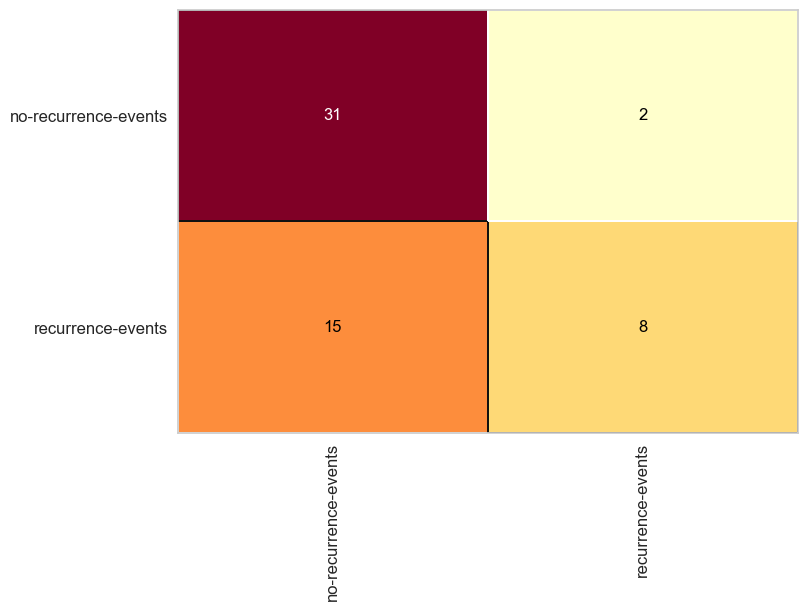

In [1908]:
# Confusion Matrix

cm = confusion_matrix(y_test, pred)
cm = ConfusionMatrix(best_model, classes=labels)
cm.fit(X_train, y_train)
cm.score(X_test, y_test)